In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
%cd /content/drive/MyDrive/smart_agriculture

/content/drive/MyDrive/smart_agriculture


In [ ]:
!ls

 efficientnet_b0.pt		        hymenoptera_data
 googlenet.pt			        hymenoptera_data.zip
 GUAVA_DATASET			        image_inference.ipynb
'Guava Dataset (Original Image)'        mobilenetv2.pt
'Guava Dataset (Original Image).rar'    pytorch_to_tflite.zip
 GUAVA_DATASET.zip		        resnet18.pt
'Guava Disease( Augmented Image)'       resnet18_tf_.zip
'Guava Disease( Augmented Image).rar'   vgg16.pt


In [ ]:
# /content/drive/MyDrive/smart_agriculture/GUAVA_DATASET

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = 'GUAVA_DATASET'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}


In [ ]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 949
     Root location: GUAVA_DATASET/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 3528
     Root location: GUAVA_DATASET/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 949
     Root location: GUAVA_DATASET/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, i

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataloaders

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': <torch.utils.data.dataloader.DataLoader at 0x7fb842db7710>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fb8434fb3d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fb8434fbed0>}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names,device

(['Disease Free', 'Phytopthora', 'Red rust', 'Scab', 'Styler and Root'],
 device(type='cuda', index=0))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


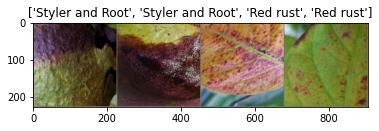

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
help(models)

Help on package torchvision.models in torchvision:

NAME
    torchvision.models

PACKAGE CONTENTS
    _utils
    alexnet
    convnext
    densenet
    detection (package)
    efficientnet
    feature_extraction
    googlenet
    inception
    mnasnet
    mobilenet
    mobilenetv2
    mobilenetv3
    optical_flow (package)
    quantization (package)
    regnet
    resnet
    segmentation (package)
    shufflenetv2
    squeezenet
    vgg
    video (package)
    vision_transformer

FILE
    /usr/local/lib/python3.7/dist-packages/torchvision/models/__init__.py




In [ ]:
# CUDA_LAUNCH_BLOCKING=1
model_ft = models.efficientnet_b0(pretrained=True)
model_ft

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [ ]:

num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))



model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
from torchsummary import summary

# vgg = models.vgg16()
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# model_ft.summery()

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7007 Acc: 0.7421
val Loss: 0.2693 Acc: 0.9125

Epoch 1/4
----------
train Loss: 0.4802 Acc: 0.8333
val Loss: 0.1258 Acc: 0.9652

Epoch 2/4
----------
train Loss: 0.3850 Acc: 0.8668
val Loss: 0.1678 Acc: 0.9273

Epoch 3/4
----------
train Loss: 0.3474 Acc: 0.8821
val Loss: 0.1540 Acc: 0.9631

Epoch 4/4
----------
train Loss: 0.2910 Acc: 0.8977
val Loss: 0.1269 Acc: 0.9642

Training complete in 5m 45s
Best val Acc: 0.965227


In [ ]:
# model_ft

In [ ]:
PATH = "resnet18.pt"

torch.save(model_ft.state_dict(), PATH)

In [ ]:
model_ft.load_state_dict(torch.load("efficientnet_b0.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


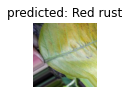

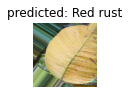

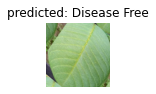

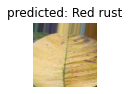

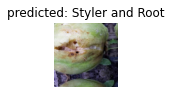

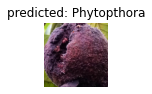

In [ ]:
visualize_model(model_ft)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix




def test_model(model):
    since = time.time()
    phase = 'test'
    running_corrects = 0
    model.eval()   # Set model to evaluate mode

    preds_all=[]
    labels_all=[]
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

       
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds_all.extend(preds.cpu().numpy().tolist())
        labels_all.extend(labels.data.cpu().numpy().tolist())
            
        running_corrects += torch.sum(preds == labels.data)
    print(classification_report(labels_all,preds_all))
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase}  Acc: {epoch_acc:.4f}')

print()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix




def train_model(model):
    since = time.time()
    phase = 'train'
    running_corrects = 0
    model.eval()   # Set model to evaluate mode

    preds_all=[]
    labels_all=[]
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

       
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds_all.extend(preds.cpu().numpy().tolist())
        labels_all.extend(labels.data.cpu().numpy().tolist())
            
        running_corrects += torch.sum(preds == labels.data)
    print(classification_report(labels_all,preds_all))
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase}  Acc: {epoch_acc:.4f}')

print()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix




def val_model(model):
    since = time.time()
    phase = 'val'
    running_corrects = 0
    model.eval()   # Set model to evaluate mode

    preds_all=[]
    labels_all=[]
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

       
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds_all.extend(preds.cpu().numpy().tolist())
        labels_all.extend(labels.data.cpu().numpy().tolist())
            
        running_corrects += torch.sum(preds == labels.data)
    print(classification_report(labels_all,preds_all))
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase}  Acc: {epoch_acc:.4f}')

print()

In [ ]:
val_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       0.99      0.94      0.97       174
           2       1.00      1.00      1.00       203
           3       0.99      0.98      0.99       173
           4       0.94      1.00      0.97       203

    accuracy                           0.98       949
   macro avg       0.99      0.98      0.98       949
weighted avg       0.98      0.98      0.98       949

val  Acc: 0.9842


In [ ]:
test_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      0.99      1.00       174
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       173
           4       1.00      1.00      1.00       203

    accuracy                           1.00       949
   macro avg       1.00      1.00      1.00       949
weighted avg       1.00      1.00      1.00       949

test  Acc: 0.9989


In [ ]:
# torch.save(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7191 Acc: 0.7354
val Loss: 0.2216 Acc: 0.9152

Epoch 1/24
----------
train Loss: 0.5978 Acc: 0.7836
val Loss: 0.1726 Acc: 0.9428

Epoch 2/24
----------
train Loss: 0.5665 Acc: 0.8043
val Loss: 0.1733 Acc: 0.9586

Epoch 3/24
----------
train Loss: 0.5392 Acc: 0.8071
val Loss: 0.2233 Acc: 0.9093

Epoch 4/24
----------
train Loss: 0.5343 Acc: 0.8158
val Loss: 0.1342 Acc: 0.9606

Epoch 5/24
----------
train Loss: 0.5306 Acc: 0.8128
val Loss: 0.1491 Acc: 0.9487

Epoch 6/24
----------
train Loss: 0.5646 Acc: 0.8063
val Loss: 0.1611 Acc: 0.9408

Epoch 7/24
----------
train Loss: 0.4382 Acc: 0.8456
val Loss: 0.1594 Acc: 0.9448

Epoch 8/24
----------
train Loss: 0.4487 Acc: 0.8440
val Loss: 0.1342 Acc: 0.9546

Epoch 9/24
----------
train Loss: 0.4306 Acc: 0.8450
val Loss: 0.1497 Acc: 0.9507

Epoch 10/24
----------
train Loss: 0.4526 Acc: 0.8353
val Loss: 0.2121 Acc: 0.9290

Epoch 11/24
----------
train Loss: 0.4322 Acc: 0.8408
val Loss: 0.1596 Acc: 0.9487

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


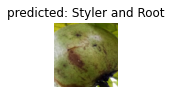

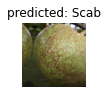

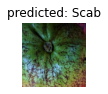

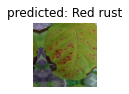

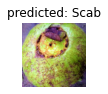

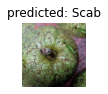

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
test_model(model_conv)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test  Acc: 0.9606
